# AIPW

In this tutorial, we are going to see how to robustly estimate treatment effects when treatment is conditionally randomly assigned, using the **Augmented Inverse Propensity Weighted** estimator, also known as **doubly-robust** estimator.

For this tutorial, I assume you are familiar with the following concepts:

- Rubin's potential outcome framework
- Propensity score weighting
- Basic machine learning

## Setting

We assume that for a set of i.i.d. subjects $i = 1, ..., n$ we observed a tuple $(X_i, T_i, Y_i)$ comprised of 

- a feature vector $X_i \in \mathbb R^n$
- a treatment assignment $T_i \in \lbrace 0, 1 \rbrace$
- a response $Y_i \in \mathbb R$

**Assumption 1 : unconfoundedness** (or ignorability, or selection on observables)

$$
\big \lbrace Y_i^{(1)} , Y_i^{(0)} \big \rbrace \ \perp \ T_i \ | \ X_i
$$

i.e. conditional on observable characteristics $X$, the treatment assignment $T$ is as good as random.

**Assumption 2: overlap** (or bounded support)

$$
\exists \eta > 0 \ : \ \eta \leq \mathbb E \left[ T_i = 1 \ \big | \ X_i = x \right] \leq 1-\eta
$$

i.e. no observation is deterministically assigned to the treatment or control group. 

## The IPW Estimator

We want to estimate the **average treatment effect**

$$
\tau(x) = \mathbb E \left[ Y^{(1)} - Y^{(0)} \ \big| \ X = x \right]
$$

We would like to obtain an unbiased estimator that satifies a central limit theorem of the form

$$
\sqrt{n} ( \hat \tau - \tau) \ \overset{d}{\to} \ N(0, V)
$$

thus enabling us to construct **confidence intervals**.

Under **unconfoundedness**, we can rewrite the average treatment effect as

$$
\tau(x) = \mathbb E \left[ Y^{(1)} - Y^{(0)} \ \big| \ X = x \right] = \mathbb E \left[ \frac{T_i Y_i}{e(X_i)} - \frac{(1-T_i) Y_i}{1-e(X_i)} \right]
$$

where $e(X_i)$ is the **propensity score** of observation $i$, 

$$
e(x) = \mathbb P \left[ T_i = 1 \ \big | \ X_i = x \right]
$$

i.e. its probability of being treated.

Note that this formulation of the average treatment effect does not depend on the potential outcomes $Y_i^{(1)}$ and $Y_i^{(0)}$, but only on the observed outcomes $Y_i$.

This formulation of the average treatment effect implies the **Inverse Propensity Weighted** estimator which is an unbiased estimator for the average treatment effect $\tau$ 

$$
\hat \tau^{*}_{IPW} = \frac{1}{n} \sum _ {i=1}^{n} \left( \frac{T_i Y_i}{e(X_i)} - \frac{(1-T_i) Y_i}{1-e(X_i)} \right)
$$

However, this estimator is **unfeasible** since we do not observe the propensity scores $e(X_i)$.

## The AIPW Estimator

A feasible estimator of the average treatment effect $\tau$ is 

$$
\hat \tau_{IPW} = \frac{1}{n} \sum_{i=1}^{n} \left( \frac{T_i Y_i}{\hat e(X_i)} - \frac{(1-T_i) Y_i}{1-\hat e(X_i)} \right)
$$

where we have replaced the propensity scores $e (X_i)$ with their estimates $\hat e (X_i)$.

With a linear model, $Y_i = \alpha T_i + \beta X_i + \varepsilon_i$, we can get a central limit theorem for $\hat \tau$. However, we want to take a non-parametric / **machine learning** approach with respect to the relationship between $Y$ and $X$.

**Advantages**

- flexible functional form for $\mathbb E[Y | X]$

**Disadvantages**

- machine learning methods have slow convergence rates
- it impacts inference, i.e. we cannot easily get a central limit theorem result to build confidence intervals

Is there a way to get around the slow rate of convergence of machine learning methods?

**Yes!** Idea: combine two predicton problems instead of one.

The **Augmented Inverse Propensity Weighted** estimator is given by

$$
\hat \tau_{IPW} = \frac{1}{n} \sum_{i=1}^{n} \left( \hat \mu^{(1)}(X_i) - \hat \mu^{(0)}(X_i) + \frac{T_i }{\hat e(X_i)} \left( Y_i - \hat \mu^{(1)}(X_i) \right) - \frac{(1-T_i) }{1-\hat e(X_i)} \left( Y_i - \hat \mu^{(0)}(X_i) \right) \right)
$$

where 

$$
\mu^{(t)}(x) = \mathbb E \left[ Y_i \ \big | \ X_i = x, T_i = t \right] \qquad ; \qquad e(x) = \mathbb E \left[ T_i = 1 \ \big | \ X_i = x \right]
$$

The formula of the AIPW estimator might seem scary at first, so let's **decompose** it into two parts.

First, 

$$
D = \frac{1}{n} \sum_{i=1}^{n} \left( \hat \mu^{(1)}(X_i) - \hat \mu^{(0)}(X_i) \right)
$$

is basically the **direct estimate** of the average treatment effect. This is a consistent estimator of the ATE but, since machine learning estimators' rate of convergence is too slow, it does not provide correct confidence intervals.

Instead, 

$$
R = \frac{1}{n} \sum_{i=1}^{n} \left(\frac{T_i }{\hat e(X_i)} \left( Y_i - \hat \mu^{(1)}(X_i) \right) - \frac{(1-T_i) }{1-\hat e(X_i)} \left( Y_i - \hat \mu^{(0)}(X_i) \right) \right)
$$

is basically **IPW applied to the residuals** $Y_i - \hat \mu^{(t)}(X_i)$ instead of $Y_i$. 

### Double Robustness

Why is the AIPW estimator so **compelling**? It just needs one of the two predictions, $\hat \mu$ and $\hat e$, to be right in order to be unbiased. Let's check it.

If $\hat \mu$ is correctly specified, i.e. $\mathbb E \left[ \hat \mu^{(t)}(x) \right] = \mathbb E \left[ Y_i \ \big | \ X_i = x, T_i = t \right]$, then

$$
\begin{aligned}
\hat \tau_{IPW} &\overset{p}{\to} \mathbb E \left[ \hat \mu^{(1)}(X_i) - \hat \mu^{(0)}(X_i) + \frac{T_i \left( Y_i - \hat \mu^{(1)}(X_i) \right)}{\hat e(X_i)} - \frac{(1-T_i) \left( Y_i - \hat \mu^{(0)}(X_i) \right)}{1-\hat e(X_i)} \right] =
\newline
&= \mathbb E \left[ \hat \mu^{(1)}(X_i) - \hat \mu^{(0)}(X_i) \right] =
\newline
&= \mathbb E \left[ Y^{(1)} - Y^{(0)} \right] =
\newline
&= \tau
\end{aligned}
$$

even if $\hat e$ is misspecified. 

The **intuition** is that the residuals $\left( Y_i - \hat \mu^{(t)}(X_i) \right)$ converge to zero and therefore IPW has no relevance.

On the other hand, if $\hat e$ is correctly specified, i.e. $\mathbb E \left[\hat e(x) \right] = \mathbb E \left[ T_i = 1 \ \big | \ X_i = x \right]$, then

$$
\begin{aligned}
\hat \tau_{IPW} &\overset{p}{\to} \mathbb E \left[ \hat \mu^{(1)}(X_i) - \hat \mu^{(0)}(X_i) + \frac{T_i \left( Y_i - \hat \mu^{(1)}(X_i) \right)}{\hat e(X_i)} - \frac{(1-T_i) \left( Y_i - \hat \mu^{(0)}(X_i) \right)}{1-\hat e(X_i)} \right] =
\newline
&= \mathbb E \left[ \frac{T_i Y_i}{\hat e(X_i)} - \frac{(1-T_i) Y_i }{1-\hat e(X_i)} + \left(1 - \frac{T_i}{\hat e(X_i)} \right) \hat \mu^{(1)}(X_i) - \left(1 - \frac{1-T_i}{1-\hat e(X_i)} \right) \hat \mu^{(0)}(X_i)  \right] =
\newline
&= \mathbb E \left[ \frac{T_i Y_i}{\hat e(X_i)} - \frac{(1-T_i) Y_i }{1-\hat e(X_i)}\right] =
\newline
&= \mathbb E \left[ Y^{(1)} - Y^{(0)} \right] =
\newline
&= \tau
\end{aligned}
$$

even if $\hat \mu$ is misspecified. 

The **intuition** is that, if we have a wrong model of $\mu(x)$ for $\mathbb E \left[ Y_i \ \big | \ X_i = x, T_i = t \right]$, it will not capture differences between treatment and control group or, even worse, it will capture wrong ones. Running IPW on the residuals we can not only recover the treatment effect but also compensate for eventual biases introduced by $\mu(x)$.

## Best Practices

**1. Check Covariate Balance**

Both IPW and AIPW were built for settings in which the treatment $T$ is not uconditionally randomly assigned, but might depend on some observables $X$. This information can be checked in two ways:

1. Produce a balance table, summarizing the covariates across treatment arms. If undonditional randomization does not hold, we expect to see significant differences across some observables
2. Plot the estimated propensity scores. If undonditional randomization holds, we expect the propensity scores to be constant

**2. Check the Overlap Assumption**

Another assumption that we can check is the **overlap** assumption, i.e. $\exists \eta \ : \ \eta \leq \mathbb E \left[ T_i = 1 \ \big | \ X_i = x \right] \leq 1-\eta$. To check this assumption we can simply check the bounds of the predicted propensity scores. If the overlap assumption is violated, we end up dividing some term of the estimator by zero.

**3. Use LOO Predictors**

It is best practice, whenever we build a prediction it is best pratice to exclude observation $i$ when fitting the algorithm for predicting $\hat \mu^{(t)} (X_i)$ or $\hat e (X_i)$. These predictors are called **Leave One Out** predictors.

## Example

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *
from src.dgp import dgp_aipw

In this example, we are going to use the following **data generating process**

- $N = 1000$
- $p = 20$
- $X_i \sim N(0, I_p)$
- $e(x) = 1 / (1 + e^{-x_1})$
- $\mu^{(0)}(x) = (x_1 + x_2)_+$
- $\mu^{(1)}(x) = (x_1 + x_3)_+ \mathbf{- 0.05}$

So that the average treatment effect is $- 0.05$.

In [3]:
dgp = dgp_aipw()
df = dgp.generate_data()
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x16,x17,x18,x19,x20,e,T,Y0,Y1,Y
0,1.624345,-0.611756,-0.528172,-1.072969,0.865408,-2.301539,1.744812,-0.761207,0.319039,-0.249370,...,-1.099891,-0.172428,-0.877858,0.042214,0.582815,0.835394,1,0.962589,0.996174,0.996174
1,-1.100619,1.144724,0.901591,0.502494,0.900856,-0.683728,-0.122890,-0.935769,-0.267888,0.530355,...,-0.012665,-1.117310,0.234416,1.659802,0.742044,0.249624,0,0.044105,-0.050000,0.044105
2,-0.191836,-0.887629,-0.747158,1.692455,0.050808,-0.636996,0.190915,2.100255,0.120159,0.617203,...,0.586623,0.838983,0.931102,0.285587,0.885141,0.452188,1,-0.050000,-0.100000,-0.100000
3,-0.754398,1.252868,0.512930,-0.298093,0.488518,-0.075572,1.131629,1.519817,2.185575,-1.396496,...,-2.022201,-0.306204,0.827975,0.230095,0.762011,0.319864,1,0.448470,-0.100000,-0.100000
4,-0.222328,-0.200758,0.186561,0.410052,0.198300,0.119009,-0.670662,0.377564,0.121821,1.129484,...,0.077340,-0.343854,0.043597,-0.620001,0.698032,0.444646,0,0.000000,-0.050000,0.000000


First, we check for covariate imbalance across treatment arms, with a **balance table**.

In [4]:
df.groupby('T').agg(['mean', 'std']).T.unstack(1).head()

T          0                   1          
        mean       std      mean       std
x1 -0.462644  0.920626  0.413837  0.882116
x2  0.007900  1.010610 -0.054072  0.991680
x3 -0.005718  0.950997 -0.042624  1.059308
x4  0.122930  0.936591  0.095082  1.004048
x5  0.032637  0.955479  0.119788  1.039616

We can also get a first (wrong) estimate of the treatment effect as a difference in means.

In [5]:
df.loc[df['T']==1, 'Y'].mean() - df.loc[df['T']==0, 'Y'].mean()

0.29838749886286686

We know this estimate is wrong since the treatment is not unconditionally randomized. Therefore, we estimate the average treatment effect using the **AIPW estimator**. 

First, we estimate the **propensity scores** $e(x)$ using `LogisticRegression`.

In [6]:
def estimate_e(df, X, model_e):
    e = model_e.fit(df[dgp.X], df['T']).predict_proba(df[dgp.X])[:,1]
    return e

In [7]:
from sklearn.linear_model import LogisticRegression as logit

e = estimate_e(df, dgp.X, logit())

A best practice is to use the `LeaveOneOut` estimator to make predictions, i.e., for each observations, build a model using the remaining observations. This procedure helps preventing overfitting bias. The main issue is that it's particularly slow since we need to fit one model per observation. However, it is parallelizable.

In [8]:
from sklearn.model_selection import cross_val_predict, LeaveOneOut

e = cross_val_predict(estimator=logit(), 
                      X=df[dgp.X], 
                      y=df['T'],
                      cv=LeaveOneOut(),
                      method='predict_proba',
                      n_jobs=-1)[:,1]

Let's check if the **bounded support** assumption is satisfied.

In [9]:
print(f'Support of e is [{min(e):.2}, {max(e):.2}]')

Support of e is [0.019, 0.97]


The support assumption is satisfied. Note that this is guaranteed with logistic regression.

We can further plot the distribution of scores. They definitely do not seem constant.

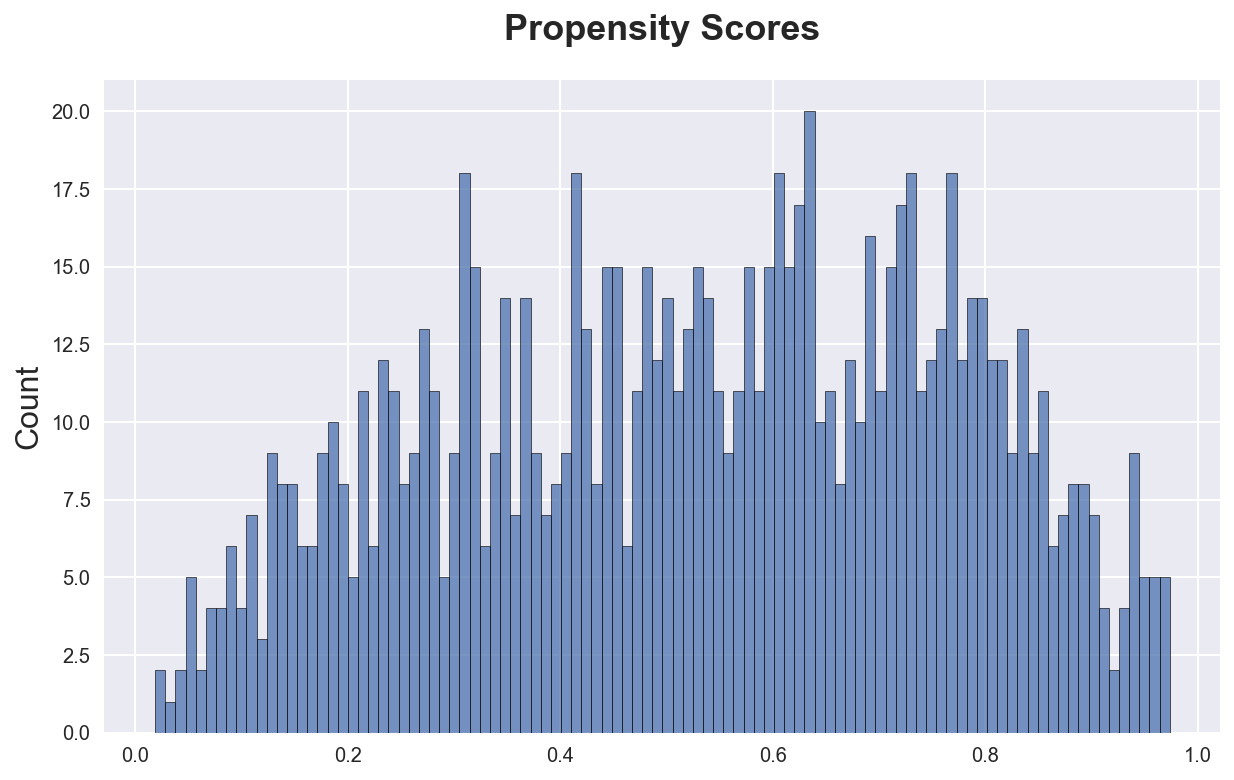

In [10]:
sns.histplot(e, bins=100).set(title='Propensity Scores');

We can now estimate the average treatment effect using the AIPW estimator. We also separately compute its components, $D$ and $R$.

We use `RandomForestRegressor` to estimate the conditional expectation of $Y$, $\hat \mu^{(t)}(x)$.

In [11]:
def estimate_mu(df, X, model_mu):
    mu = model_mu.fit(df[X + ['T']], df['Y'])
    mu0 = mu.predict(df[X + ['T']].assign(T=0))
    mu1 = mu.predict(df[X + ['T']].assign(T=1))
    return mu0, mu1

In [12]:
from sklearn.ensemble import RandomForestRegressor as rfr

mu0, mu1 = estimate_mu(df, dgp.X, rfr(max_features=5))

We now have all the elements to estimate AIPW

In [13]:
def AIPW(df, X, e, mu0, mu1):
    D = mu1 - mu0
    R = df['T'] / e * (df['Y'] - mu1) - (1-df['T']) / (1-e) * (df['Y'] - mu0)
    tau_AIPW = D + R
    return D, R, tau_AIPW

In [14]:
D, R, hat_tau_AIPW = AIPW(df, dgp.X, e, mu0, mu1)
print(f"Mean: {np.mean(hat_tau_AIPW):.2} and var {np.var(hat_tau_AIPW):.2}")

Mean: -0.02 and var 0.48


Our estimate is now closer to the true value, $-0.05$. We plot the distribution of $\hat \tau_i^{AIPW}$ below.

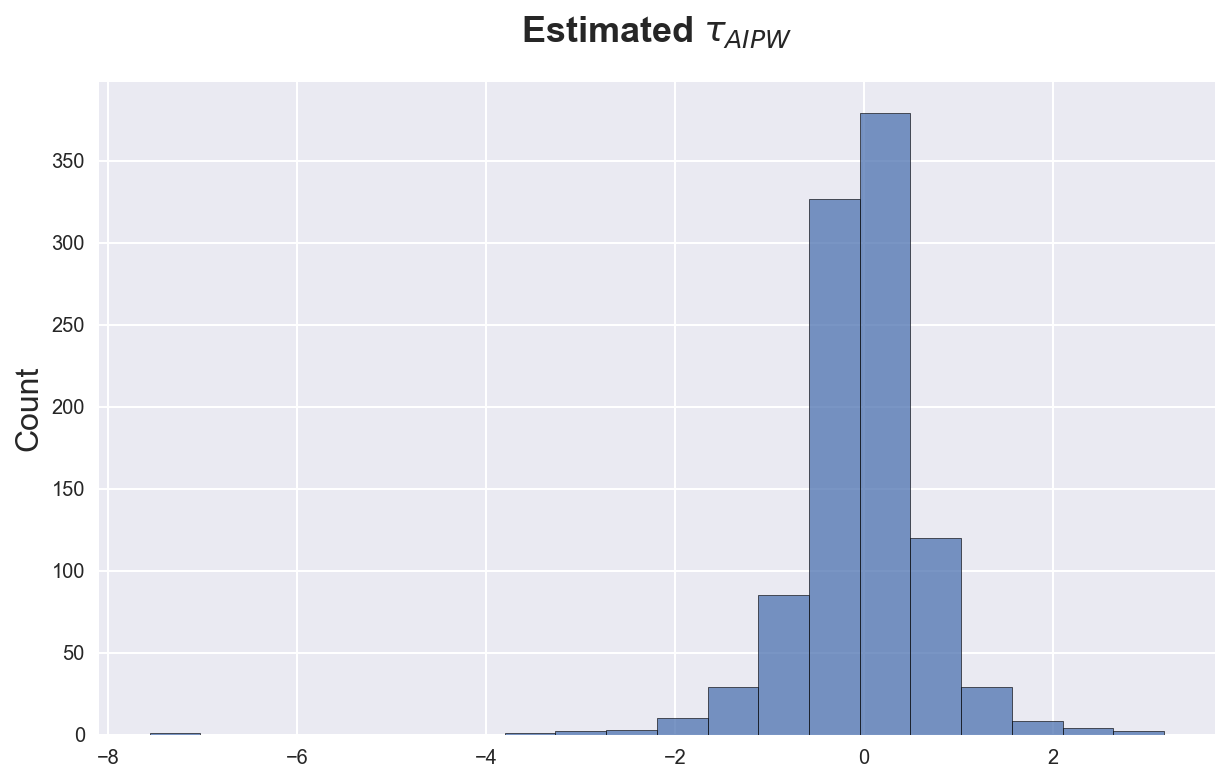

In [15]:
sns.histplot(hat_tau_AIPW, bins=20).set(title='Estimated $τ_{AIPW}$');

To visualize the impact of the AIPW correction, we simulate the distribution of the AIPW estimator and its components.

In [16]:
def simulate_AIPW(k):
    df = dgp_aipw().generate_data(seed=k)
    e = estimate_e(df, dgp.X, logit())
    mu0, mu1 = estimate_mu(df, dgp.X, rfr())
    aipw = AIPW(df, dgp.X, e, mu0, mu1)
    return np.mean(aipw, axis=1)

In [17]:
from joblib import Parallel, delayed

def distribution_AIPW(t):
    r = Parallel(n_jobs=8)(delayed(simulate_AIPW)(i) for i in range(100))
    sim_tau_AIPW = pd.DataFrame(r, columns=['Direct', 'Correction', '$τ_{AIPW}$'])
    plot = sns.boxplot(data=pd.melt(sim_tau_AIPW), x='variable', y='value', linewidth=2);
    plot.set(title=t, xlabel='', ylabel='')
    plot.axhline(-0.05, c='r', ls=':');

Below we plot the AIPW estimator and its components.

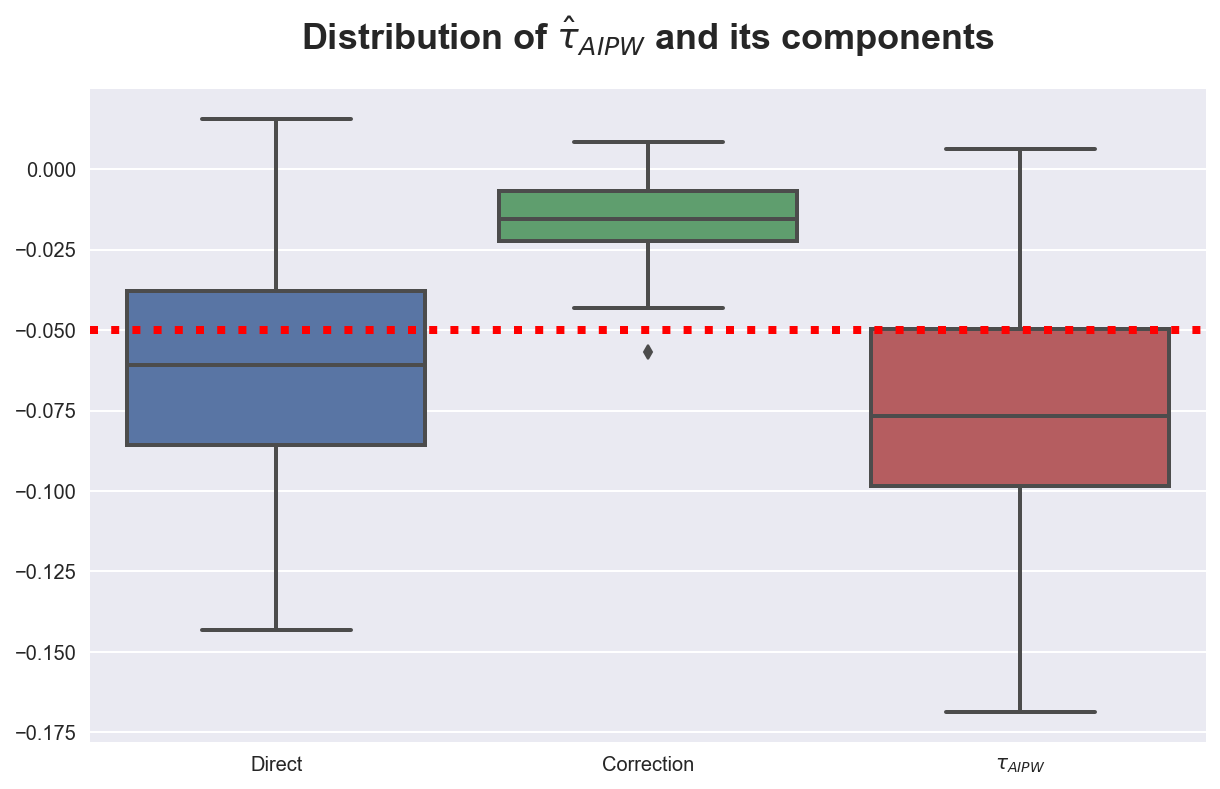

In [18]:
distribution_AIPW("Distribution of $\hat τ_{AIPW}$ and its components")

Since the model is well specified, the correction is close to zero and the final estimates are very close to the direct estimates.

We now turn into checking the **double-robustness** of the estimator. 

What happens if we misspecify the propensity score? Let's assume now that the propensity score is $\hat e(X_i) = 1 /(1 + e^{x_4})$.

In [19]:
def estimate_e(df, X, model_e):
    e = 1 / (1 + np.exp(df['x4']))
    return e

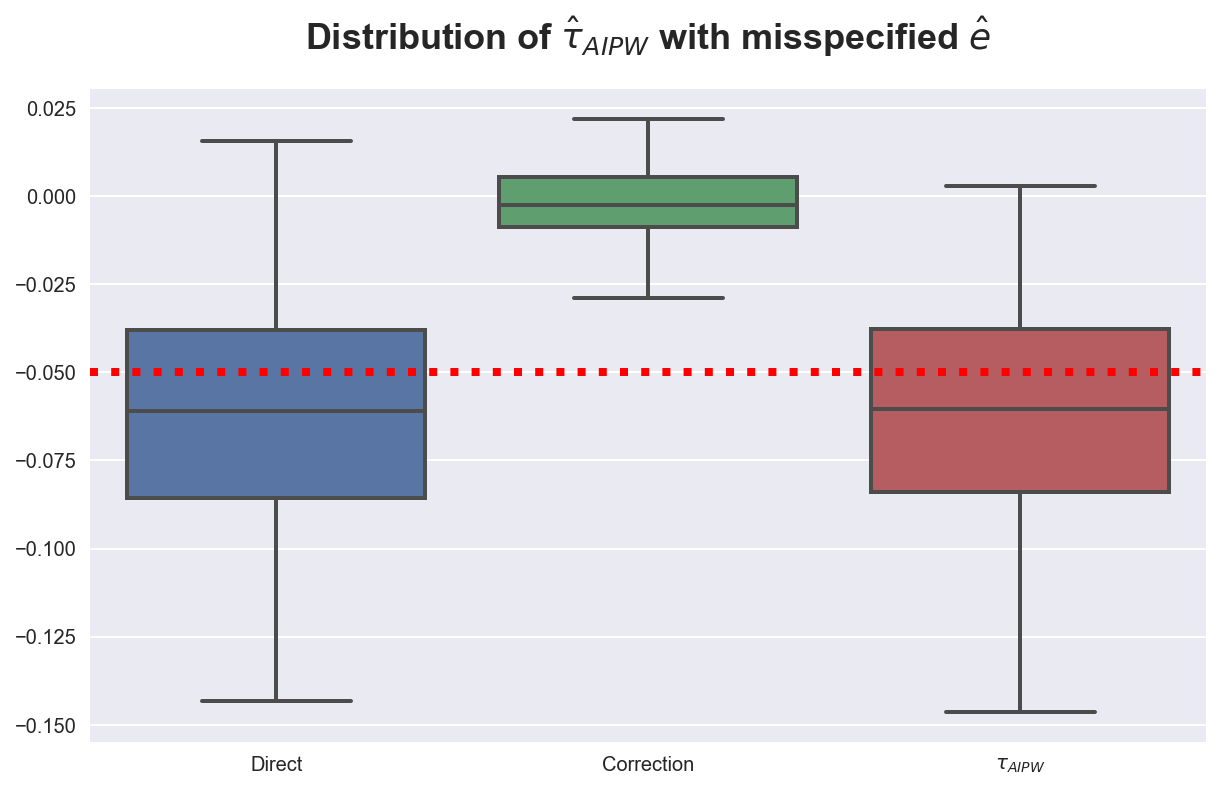

In [20]:
distribution_AIPW("Distribution of $\hat τ_{AIPW}$ with misspecified $\hat e$")

Not much changes. In fact, since we have a good direct model of $\mu(x)$, the residuals are small and the correction does not play a big role.

Let's now misspecify $\mu(x)$ and assume it is equal to $|x_5|$.

In [21]:
def estimate_e(df, X, model_e):
    e = model_e.fit(df[dgp.X], df['T']).predict_proba(df[dgp.X])[:,1]
    return e

def estimate_mu(df, X, model_mu):
    mu0 = 0
    mu1 = np.abs(df['x6'])
    return mu0, mu1

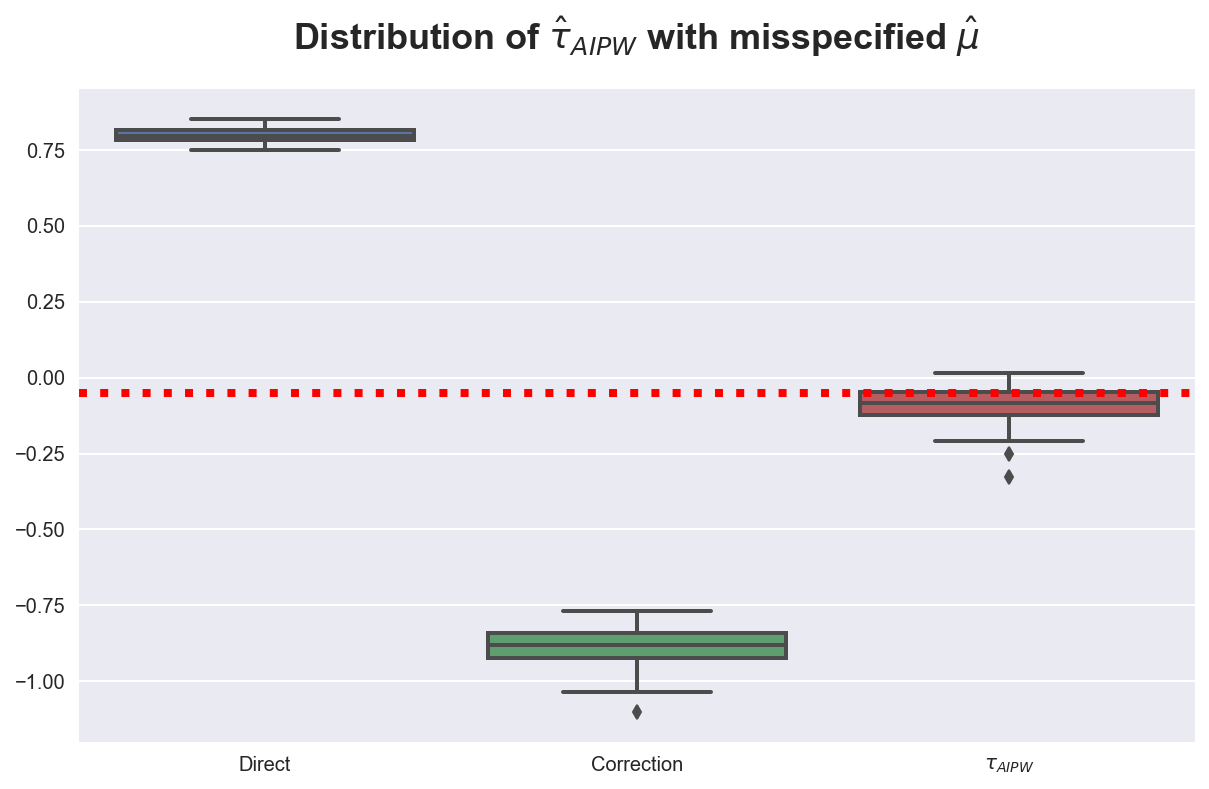

In [22]:
distribution_AIPW("Distribution of $\hat τ_{AIPW}$ with misspecified $\hat μ$")

In this case, the correction term is crucial and fully offsets the bias of the original estimator. 

The [`EconML`](https://econml.azurewebsites.net/index.html) library offers a plug and play estimator, `LinearDRLearner`.

In [32]:
from econml.drlearner import LinearDRLearner

model = LinearDRLearner(model_propensity=logit(), model_regression=rfr())
model.fit(Y=df[dgp.Y], X=df[dgp.X], T=df[dgp.T]);

The model directly gives us the average treatment effect.

In [42]:
model.ate_inference(X=df[dgp.X].values, T0=0, T1=1).summary().tables[0]

mean_point,stderr_mean,zstat,pvalue,ci_mean_lower,ci_mean_upper
-0.087,0.036,-2.438,0.015,-0.157,-0.017


The estimate is statistically different from zero and the confidence interval includes the true value of $-0.05$.

## Research Paper Replication

TBD

## Business Case

TBD

## References

- Original paper: [An Introduction to the Augmented Inverse Propensity Weighted Estimator](https://www.cambridge.org/core/journals/political-analysis/article/abs/an-introduction-to-the-augmented-inverse-propensity-weighted-estimator/4B1B8301E46F4432C4DCC91FE20780DB)
- [Video lecture](https://www.youtube.com/watch?v=IfZHUFFlsGc) by Prof. Stefan Wager (Stanford)